In [1]:
using Pkg
using Plots, Random, Distributions
using BenchmarkTools

In [2]:
d = Cauchy(0,1)
u = truncated(d,-pi,pi)

Truncated(Cauchy{Float64}(μ=0.0, σ=1.0); lower=-3.141592653589793, upper=3.141592653589793)

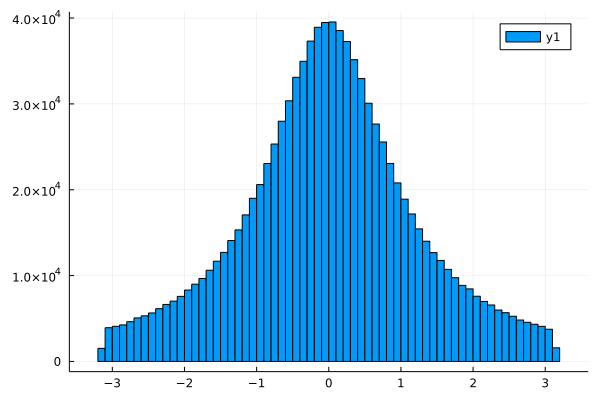

In [3]:
histogram(rand(u,1000000),bins= 100)

In [4]:
@benchmark rand(d,100000)

BenchmarkTools.Trial: 2108 samples with 1 evaluation.
 Range (min … max):  2.142 ms …   5.088 ms  ┊ GC (min … max): 0.00% … 51.45%
 Time  (median):     2.315 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.368 ms ± 330.350 μs  ┊ GC (mean ± σ):  1.78% ±  6.65%

  ▃  █▇▄▁                                                      
  █▇▃█████▃▅▅▆▆▁▆▄▅▆▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▄▆▅ █
  2.14 ms      Histogram: log(frequency) by time      4.77 ms <

 Memory estimate: 781.30 KiB, allocs estimate: 2.

# ODE Test

In [2]:
using Pkg
using Plots, Random, Distributions
using BenchmarkTools
using DifferentialEquations, LinearAlgebra, StaticArrays

In [3]:
N = 3200
Aij = ones((N,N)) - 1I;

gω = Cauchy(0,1)
g𝜽 = Uniform(-pi,pi) 
Kc = 2/(pi*pdf(gω,0))
theta = rand(g𝜽,N);
omega = rand(gω,N);
K = 3
tspan = (0.0,10.0)

(0.0, 10.0)

In [49]:
i,j = theta,theta'
# sin!!!!! = sin.(j.-i)
inter = Aij.*sin.(j.-i)
inter! = @.sin(j-i)*Aij
inter==inter!

true

In [4]:
function r_psi(u)
    rpsi = (1/N)*sum(exp.(u*1im))
    r = abs(rpsi)
    psi = angle(rpsi)
    return r, psi
end

function kuramoto_rk4(u,t)
    i,j = u,u'
    inter = @.sin(j-i)*Aij
    return theta = vec(omega + K*sum(inter,dims=2)/N)
end
function kuramoto_mean_rk4(u,t)
    r,psi = r_psi(u)
    dxdu = vec(omega + K*r*sin.(-(u.-psi)))
    return dxdu
end
function kuramoto_mean(u,p,t)
    rpsi = (1//N)*sum(exp.(u*1im))
    dxdu = vec(omega + K*abs(rpsi)*sin.(-(u.-angle(rpsi))))
    return dxdu
end
function kuramoto_mean(u,p,t)
    rpsi = (1//N)*sum(exp.(u*1im))
    dxdu = vec(omega + K*abs(rpsi)*sin.(-(u.-angle(rpsi))))
    return dxdu
end
function kuramoto(u,p,t)
    i,j = u,u'
    inter = @.sin(j-i)*Aij
    return theta = vec(omega + K*sum(inter,dims=2)/N)
end

kuramoto (generic function with 1 method)

In [6]:
function rungekutta4(f, y0, t)
    n = length(t)
    y = zeros((n, length(y0)))
    y[1,:] = y0
    for i in 1:n-1
        h = t[i+1] - t[i]
        k1 = f(y[i,:], t[i])
        k2 = f(y[i,:] + k1 * h/2, t[i] + h/2)
        k3 = f(y[i,:] + k2 * h/2, t[i] + h/2)
        k4 = f(y[i,:] + k3 * h, t[i] + h)
        y[i+1,:] = y[i,:] + (h/6) * (k1 + 2k2 + 2k3 + k4)
    end
    return y
end

rungekutta4 (generic function with 1 method)

In [9]:
t = range(0,1000,100001)
# length(t)

0.0:0.01:1000.0

In [10]:
@btime sol = rungekutta4(kuramoto_mean_rk4,theta,t)

In [16]:
prob = ODEProblem(kuramoto_mean,theta,tspan);

In [79]:
temp = rand(25600)
@benchmark $temp.-3

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   31.600 μs … 79.478 ms  ┊ GC (min … max):  0.00% … 99.86%
 Time  (median):      83.600 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   110.508 μs ±  1.373 ms  ┊ GC (mean ± σ):  27.44% ±  2.23%

   ▂                    ▁▃▁▂▂▁   ▃▃▂▄▂▃▄▄▆█▇▄▄▄▂▃▁              
  ▃███▇▆▄▅▄▄▅▆▅▅▆▆▆██▅▆▆██████████████████████████▇▇▆▅▄▄▄▃▃▂▂▂ ▅
  31.6 μs         Histogram: frequency by time          126 μs <

 Memory estimate: 200.05 KiB, allocs estimate: 2.

In [3]:
temp = rand(x)
temp2  = 3*ones(x)

LoadError: UndefVarError: x not defined

In [46]:
N = [100,200,400,800,1600,3200,6400,12800,25600]
for x in N
    temp = rand(x)
    time = @time temp.-3
    println("Now N is ",x,mean(time))
    # @btime $temp - $temp2
end

  0.038642 seconds (68.68 k allocations: 5.544 MiB, 99.94% compilation time)
Now N is 100-2.467628254342577
  0.000010 seconds (3 allocations: 1.828 KiB)
Now N is 200-2.5292235674790464
  0.000009 seconds (3 allocations: 3.312 KiB)
Now N is 400-2.4909599834910163
  0.000003 seconds (3 allocations: 6.438 KiB)
Now N is 800-2.4933148890859567
  0.000003 seconds (3 allocations: 12.688 KiB)
Now N is 1600-2.5100089043815386
  0.000012 seconds (4 allocations: 25.109 KiB)
Now N is 3200-2.5021941191470685
  0.000023 seconds (4 allocations: 50.109 KiB)
Now N is 6400-2.5025332585135827
  0.000043 seconds (4 allocations: 100.109 KiB)
Now N is 12800-2.499905903016722
  0.000064 seconds (4 allocations: 200.109 KiB)
Now N is 25600-2.500482424388777


In [65]:
N = [100,200,400,800,1600,3200,6400]
for x in N
    temp = rand(x)
    temp2  = 3*ones(x)
    time = @btime $temp-$temp2
    println("Now N is ",x)
end

  6.075 μs (2 allocations: 78.17 KiB)
Now N is 100
  23.000 μs (2 allocations: 312.55 KiB)
Now N is 200
  199.000 μs (2 allocations: 1.22 MiB)
Now N is 400
  833.200 μs (2 allocations: 4.88 MiB)
Now N is 800
  4.022 ms (2 allocations: 19.53 MiB)
Now N is 1600
  17.441 ms (2 allocations: 78.13 MiB)
Now N is 3200
  69.704 ms (2 allocations: 312.50 MiB)
Now N is 6400


In [1]:
x = 1000
temp = rand(x,x)
temp2  = 3*ones(x,x)
temp*temp2

1000×1000 Matrix{Float64}:
 1510.45  1510.45  1510.45  1510.45  …  1510.45  1510.45  1510.45  1510.45
 1530.25  1530.25  1530.25  1530.25     1530.25  1530.25  1530.25  1530.25
 1560.65  1560.65  1560.65  1560.65     1560.65  1560.65  1560.65  1560.65
 1466.9   1466.9   1466.9   1466.9      1466.9   1466.9   1466.9   1466.9
 1532.38  1532.38  1532.38  1532.38     1532.38  1532.38  1532.38  1532.38
 1489.94  1489.94  1489.94  1489.94  …  1489.94  1489.94  1489.94  1489.94
 1491.03  1491.03  1491.03  1491.03     1491.03  1491.03  1491.03  1491.03
 1496.74  1496.74  1496.74  1496.74     1496.74  1496.74  1496.74  1496.74
 1490.82  1490.82  1490.82  1490.82     1490.82  1490.82  1490.82  1490.82
 1485.26  1485.26  1485.26  1485.26     1485.26  1485.26  1485.26  1485.26
 1440.32  1440.32  1440.32  1440.32  …  1440.32  1440.32  1440.32  1440.32
 1515.83  1515.83  1515.83  1515.83     1515.83  1515.83  1515.83  1515.83
 1519.88  1519.88  1519.88  1519.88     1519.88  1519.88  1519.88  1519.88

In [3]:
temp = [1 2; 3 4]
temp2 = [3 4;5 6]

2×2 Matrix{Int64}:
 3  4
 5  6

In [11]:
temp.*temp2

2×2 Matrix{Int64}:
  3   8
 15  24

In [6]:
temp * temp2

2×2 Matrix{Int64}:
 13  16
 29  36